# CSCE 823 Homework 2 Example Solution

Original Author: Lt Garrett Alarcon - (CSCE 823, 2019)


In [1]:
import os
import numpy as np
import pandas as pd
import copy
import keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras import callbacks
from keras import metrics
from matplotlib import pyplot
from matplotlib import cm

RUN_CONFIGURATION_LOOP = False

Using TensorFlow backend.
C:\Users\brett\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\brett\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\brett\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\brett\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Step 1. Import Data

In [2]:
TrainingSet = pd.read_csv('CSCE823_HW2_regression_non_testdata.csv')
TestSet = pd.read_csv('CSCE823_HW2_regression_testdata.csv')
TrainingSet = TrainingSet.values
TestSet = TestSet.values
np.random.shuffle(TrainingSet)
np.random.shuffle(TestSet)
X_train = TrainingSet[:,0:2]
y_train = TrainingSet[:,2]
X_test = TestSet[:,0:2]
y_test = TestSet[:,2]

### Step 2a. Build Function for Z Calculation

In [3]:
def computeZ(x1,x2):
    
    z = x1**2-x2**2
    
    return z

### Step 2b. Build Function for 3D Surface Plot

In [4]:
def build3DSurface(Xdata, ydata):
    x = Xdata[:,0]
    y = Xdata[:,1]
    z = computeZ(x,y)
    zdata = ydata
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)
    ax.scatter3D(x, y, zdata, c=zdata, cmap='Greens')
    plt.title('Raw Errors on Saddle Surface')
    plt.ylabel('x2')
    plt.xlabel('x1')

### Step 2c. Explore Data with 2D and 3D Plots

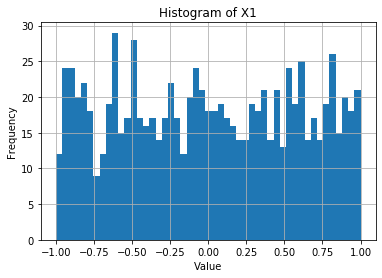

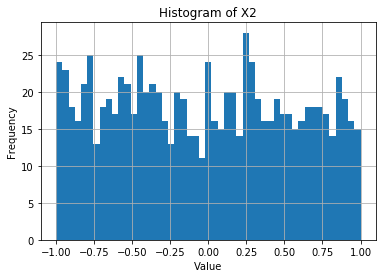

In [5]:
plt.figure(1)
bins = np.linspace(-1,1,50)
plt.hist(X_train[:,0],bins)
plt.title('Histogram of X1')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.grid(True)

plt.figure(2)
plt.hist(X_train[:,1],bins)
plt.title('Histogram of X2')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.grid(True)

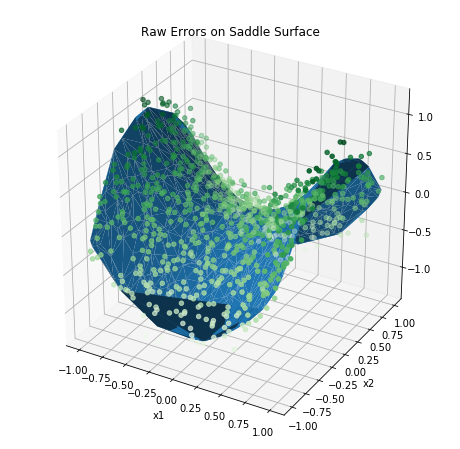

In [6]:
build3DSurface(X_train, y_train)
plt.show()

### Step 2d. Determine Raw Error

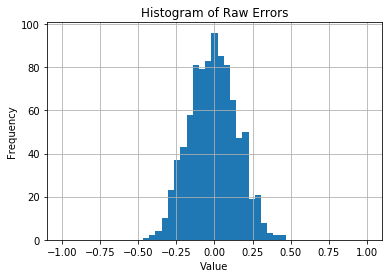

In [7]:
errors = np.zeros(len(X_train))
errors = computeZ(X_train[:,0], X_train[:,1]) - y_train

plt.figure(3)
plt.hist(errors, bins)
plt.title('Histogram of Raw Errors')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.grid(True)

The histogram of the raw errors resembles a normal distribution. It doesn't look particulary skewed in any direction, and fairly centered around 0. The noise in the data resembles random gaussian noise. It shouldn't affect the model that much, but it will depend on the configuration of the network and the activation functions used. There doesn't look to be any extreme outliers.

### Step 2e. Scatterplot of True Saddle Values vs Raw Errors

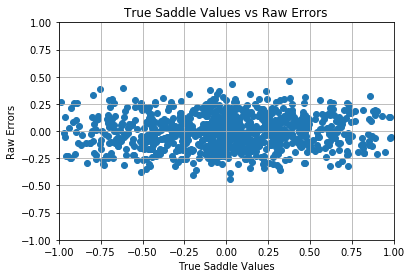

In [8]:
plt.figure(3)
plt.scatter(computeZ(X_train[:,0], X_train[:,1]), errors)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title('True Saddle Values vs Raw Errors')
plt.xlabel('True Saddle Values')
plt.ylabel('Raw Errors')
plt.grid(True)

The errors in the scatterplot closely mirror that which was shown in the histogram. They are closely centered around 0 with a horizontal linear feel. They could be argued to resemble residuals that are uniformly spread, but they are a little too centered between -0.5 - 0.5.

### Step 2f. Report Metrics on Error

In [9]:
mse = np.dot(errors, errors.T)/len(errors)
rmse = np.sqrt(mse)
mae = np.sum(np.absolute(errors))/len(errors)
print("The MSE = " + str(mse))
print("The RMSE = " + str(rmse))
print("The MAE = " + str(mae))

The MSE = 0.02363522500631578
The RMSE = 0.15373751983922396
The MAE = 0.12465195801133512


### Step 3. Prepare Data for Training/Validation

In [10]:
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, train_size = 0.75, random_state=1)

### Step 4. Build Function to Return Compiled Keras Model

In [11]:
def ANNmodel(layers, nodes, learningRate, activationFunc, opt):
    
    model = Sequential()
    model.add(Dense(nodes, input_dim = 2)) # Input Layer
    
    for i in range(0,layers): # Create hidden layers
        model.add(Dense(nodes, activation = activationFunc))
        
    model.add(Dense(1, activation = 'tanh')) # Output layer

    engine = opt(lr=learningRate)
    model.compile(optimizer=engine, loss='mean_squared_error', metrics=[metrics.mse, metrics.mae])
    
    return model

### Step 5. Define Model Configurations

In [12]:
nodes = np.array([5,10])
layers = np.array([1,2])
lrnRate = np.array([0.09, 0.18])
actFunc = np.array(['tanh', 'sigmoid'])
optimizer = np.array([optimizers.adam, optimizers.SGD])

### Step 6a. Train Configurations

In [13]:
if RUN_CONFIGURATION_LOOP == True:
     
    h = 0

    for i in range(0,2):
        for j in range(0,2):
            for k in range(0,2):
                for n in range(0,2):
                    for m in range(0,2):

                        model = ANNmodel(layers[i], nodes[j], lrnRate[k], actFunc[n], optimizer[m])
                        history = model.fit(X_trn, y_trn, validation_data=(X_val,y_val), epochs=80, batch_size=50, verbose = 0, callbacks = None)
                        print('Parameters: '+str(layers[i])+', '+str(nodes[j])+', '+str(lrnRate[k])+', '+actFunc[n]+', '+str(optimizer[m]))

                        plt.figure(h)
                        plt.plot(history.history['mean_squared_error'])
                        plt.plot(history.history['mean_absolute_error'])
                        print("Final MSE = " + str(history.history['mean_squared_error'][-1]))
                        print("")

                        h = h+1

### Step 6b. Report Best Configuration

The best configuration is:

- Nodes: 10
- Hidden Layers: 1
- Learning Rate: 0.09
- Activation Function: Tanh
- Optimizer: SGD

I believe this configuration worked the best because of the optimizer, learning rate, and activation function. In examining the other choices, a sigmoid activation function in the hidden layer, along with the SGD optimizer produced poor results. Sigmoid with adam did better, but only when the learninig rate was lower. It also performed better with one layer instead of two. Overall the tanh function performed the best for multiple configurations. The SGD optimizer worked best with the tanh activation function, and with the lower learning rate. When the extra layer was added, the model still performed but not as well. Therefore the combination of the lower learning rate paired with the tanh activation function and SGD optimizer performed the best. The number of nodes didn't seem to have a large impact on performance. It might have to be increased or decreased more in order to explore that relationship.

### Step 7. Select Best Configuration

In [14]:
model = ANNmodel(1, 10, 0.09, 'tanh', optimizers.SGD)

### Step 8. Retrain Model

In [15]:
history = model.fit(X_train, y_train, epochs=80, batch_size=50, verbose = 0, callbacks = None)

InternalError: 2 root error(s) found.
  (0) Internal: Blas GEMM launch failed : a.shape=(50, 2), b.shape=(2, 10), m=50, n=10, k=2
	 [[{{node dense_1/MatMul}}]]
	 [[metrics/mean_squared_error/Identity/_79]]
  (1) Internal: Blas GEMM launch failed : a.shape=(50, 2), b.shape=(2, 10), m=50, n=10, k=2
	 [[{{node dense_1/MatMul}}]]
0 successful operations.
0 derived errors ignored.

### Step 9a. Run Predictions on Non-Test Data

In [ ]:
y = model.predict(X_train, batch_size = 50)

### Step 9b. Determine Prediction Errors and Create Histogram

In [ ]:
yTrue = computeZ(X_train[:,0], X_train[:,1])
NewError = yTrue - y[:,0]

plt.hist(errors, bins, alpha = 0.8, label = 'Raw Errors')
plt.hist(NewError, bins, alpha = 0.6, label = 'Predicted Errors')
plt.title('Histogram of Raw Errors and Predicted Errors')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.legend()
plt.grid(True)

The predicted errors are much better than the raw errors from the noise. Majority of the values are centered around 0. The model seems to have been able to de-noise the dataset.

### Step 9c. Scatterplot of True Values vs Prediction Errors

In [ ]:
plt.scatter(computeZ(X_train[:,0], X_train[:,1]), NewError)
plt.title('True Saddle Values vs Predicted')
plt.xlabel('True Saddle Values')
plt.ylabel('Predicted Errors')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid(True)

The errors are much tighter and closer to 0 than the raw errors from the noise. But there is now a pattern in the residuals which is indicative of the non-linear nature of the saddle function. We can also see that the model performed worse with saddle values that closer to -1 and 1, as we reached the outer bounds of the saddle.

### Step 9d. Report Metrics

In [ ]:
mse = np.dot(NewError, NewError.T)/len(NewError)
rmse = np.sqrt(mse)
mae = np.sum(np.absolute(NewError))/len(NewError)
print("The MSE = " + str(mse))
print("The RMSE = " + str(rmse))
print("The MAE = " + str(mae))

The predicted error rates beat the same performance measures on raw errors caused by data noise by a significant amount. This leads more credence that the model is performing as shown above, and removing the noise from the original dataset.

### 10. Evaluate Model on Test Set

In [ ]:
scores = model.evaluate(X_test, y_test, batch_size = 50)
print(scores)
y = model.predict(X_test, batch_size = 50)

### Step 10a. Create 3D Plot of Values

In [ ]:
build3DSurface(X_test, y[:,0])
plt.show()

As suggested by the scatterplot and histogram of the predicted errors, the model performed excellent in all areas except near the boundaries of -1 and 1 for x1 and x2

### Step 10b. Histogram of Prediction Errors

In [ ]:
yTrue = computeZ(X_test[:,0], X_test[:,1])
TestError = np.zeros(len(X_test))
TestError = yTrue - y[:,0]

plt.hist(TestError, bins)
plt.title('Histogram of Errors')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.grid(True)

### Step 10c. Scatterplot of Prediction Errors

In [ ]:
plt.scatter(yTrue, TestError)
plt.title('True Saddle Values vs Predicted Errors')
plt.xlabel('True Saddle Values')
plt.ylabel('Predicted Errors')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid(True)

Looks very similiar to the scatterplot for the training set in step 9. The model performs well even on the test set indicating its ability to generalize. It still has the same issues around saddle values of -1 and 1.

In [ ]:
mse = np.dot(TestError, TestError.T)/len(TestError)
rmse = np.sqrt(mse)
mae = np.sum(np.absolute(TestError))/len(TestError)
print("The MSE = " + str(mse))
print("The RMSE = " + str(rmse))
print("The MAE = " + str(mae))

While the performance metrics are slightly higher than the training set, this is expected. Since test set performance will always be close to the same or worse than traininig set performance. But like the training set, the model with the test set performed leagues better than the set with just the raw noise. Again, showing its ability to remove noise from the data set.

The numbers above are also confirmed with the model's evaluate function, which produced the same metrics.